<a href="https://colab.research.google.com/github/kunalyadav0954/Number_Generator_GAN/blob/main/First_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
We will build and train a GAN that can generate hand-written images of digits (0-9). We will be using PyTorch [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

### Learning Objectives
1.   Build the generator and discriminator components of a GAN from scratch.
2.   Create generator and discriminator loss functions.
3.   Train the GAN and visualize the generated images.

# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/Projects/First_GAN')

# Importing Required Libraries :

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Creating a function for visualizing images

In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images that the discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](MnistExamples.png)

## Generator
The first step is to build the generator component.

We will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (you use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) so the output can be transformed in complex ways.

In [5]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

## Building the generator class. 

It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

Finally, the forward pass function takes in a noise vector and generates an image of the output dimension using the neural network. 

In [6]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise
To be able to use the generator, we will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. We will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, we will generate all the noise vectors at once.

Note that whenever we create a new tensor using torch.ones, torch.zeros, or torch.randn, we either need to create it on the target device, e.g. `torch.ones(3, 3, device=device)`, or move it onto the target device using `torch.ones(3, 3).to(device)`. We do not need to do this if we're creating a tensor by manipulating another tensor or by using a variation that defaults the device to the input, such as `torch.ones_like`. In general, we use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros` where possible.


In [7]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    return torch.randn(n_samples, z_dim, device=device )

## Discriminator
The second component that we need to construct is the discriminator. As with the generator component, we will start by creating a function that builds a neural network block for the discriminator.

*Note: We use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient.* 

In [8]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

Now you we use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that we do not need a sigmoid after the output layer since it is included in the loss function.


In [9]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

## Training
Now we can put it all together!
First, we will set our parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times we iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, we will load the MNIST dataset as tensors using a dataloader.


In [10]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda'

Now, we can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before we train our GAN, we will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, we will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that we have already defined a loss function earlier (`criterion`) and it is encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If we use `torch.ones` or `torch.zeros`, we'll need to pass `device=device` to them.

In [12]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(n_samples=num_images, z_dim=z_dim, device=device)
    fake_images = gen(noise) # fake images of shape (num_images,im_dim=784)
    fake_images_detached = fake_images.detach()  # creates a new detached tensor from the graph
    disc_predictions_fake = disc(fake_images_detached) # of shape(num_images,1)
    ground_truth_fake = torch.zeros_like(disc_predictions_fake)
    fake_loss = criterion(disc_predictions_fake, ground_truth_fake)
    disc_predictions_real = disc(real) 
    ground_truth_real = torch.ones_like(disc_predictions_real)
    real_loss = criterion(disc_predictions_real, ground_truth_real)
    disc_loss = (real_loss + fake_loss)/2

    return disc_loss

In [13]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(n_samples=num_images, z_dim=z_dim, device=device)
    fake_images = gen(noise)
    disc_predictions_fake = disc(fake_images)
    ground_truth_fake = torch.ones_like(disc_predictions_fake)
    gen_loss = criterion(disc_predictions_fake, ground_truth_fake)
    
    return gen_loss

Finally, we can put everything together! For each epoch, we will process the entire dataset in batches. For every batch, we will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that we may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN.

Epoch 1, step 500: Generator loss: 1.3089743061065675, discriminator loss: 0.4278038228750235


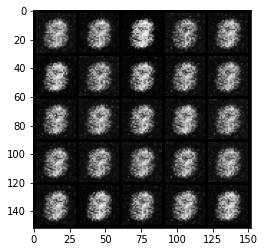

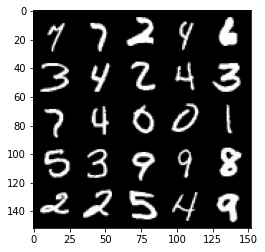

Epoch 2, step 1000: Generator loss: 1.6424537887573232, discriminator loss: 0.3005779424309729


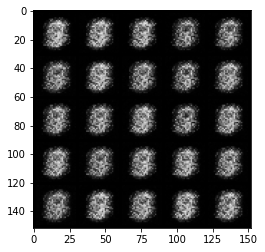

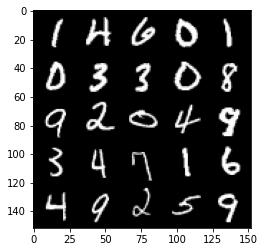

Epoch 3, step 1500: Generator loss: 1.8673029911518104, discriminator loss: 0.19012139713764203


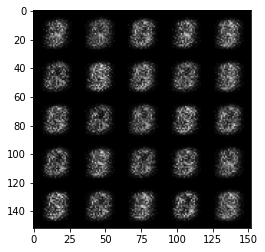

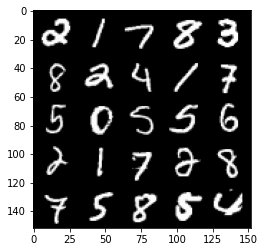

Epoch 4, step 2000: Generator loss: 1.676481014251709, discriminator loss: 0.21569166409969337


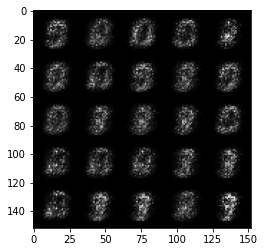

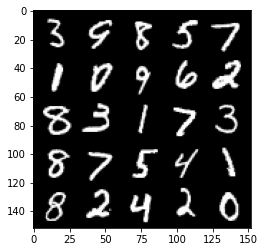

Epoch 5, step 2500: Generator loss: 1.725798089265825, discriminator loss: 0.19323859578371036


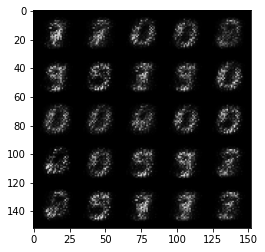

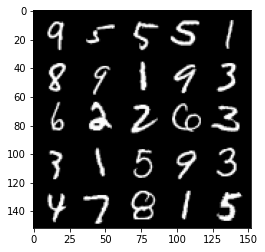

Epoch 6, step 3000: Generator loss: 1.9897689745426186, discriminator loss: 0.16582322832941992


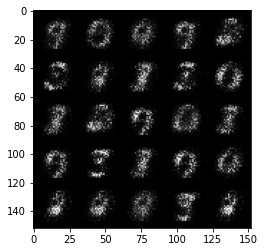

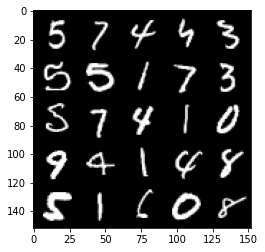

Epoch 7, step 3500: Generator loss: 2.4506110796928406, discriminator loss: 0.12299862389266489


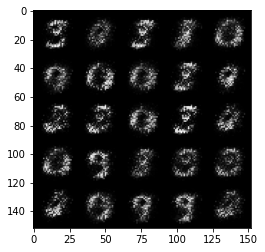

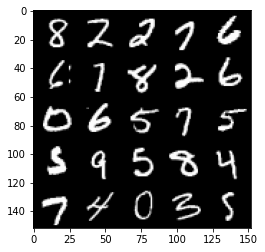

Epoch 8, step 4000: Generator loss: 2.8239986257553142, discriminator loss: 0.10174687479436409


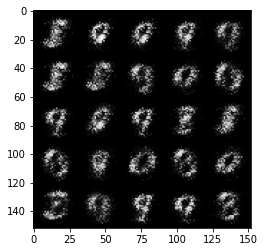

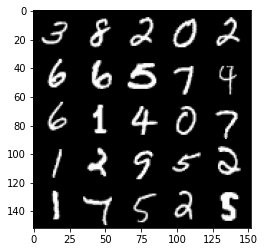

Epoch 9, step 4500: Generator loss: 3.2205783929824823, discriminator loss: 0.09610268446803089


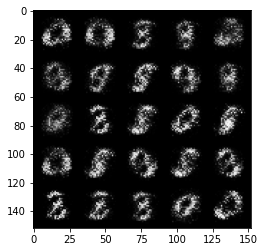

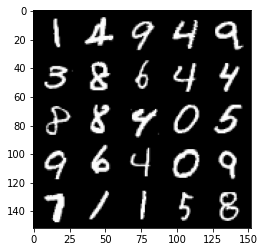

Epoch 10, step 5000: Generator loss: 3.415967521190644, discriminator loss: 0.08729330606758601


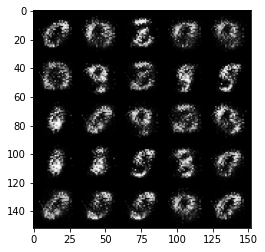

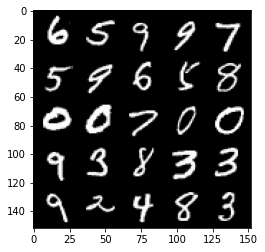

Epoch 11, step 5500: Generator loss: 3.6948441157341008, discriminator loss: 0.06933848944306373


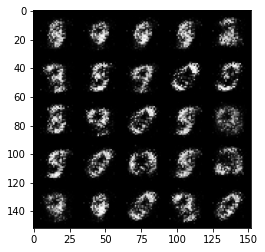

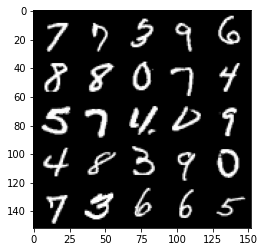

Epoch 12, step 6000: Generator loss: 3.858316631317141, discriminator loss: 0.058927911765873385


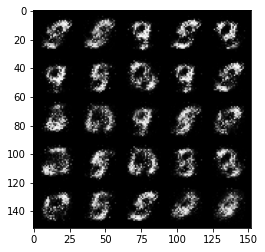

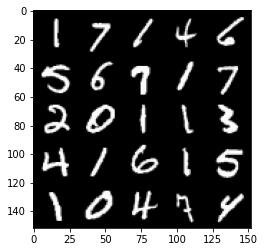

Epoch 13, step 6500: Generator loss: 3.9778646421432526, discriminator loss: 0.06269012045860296


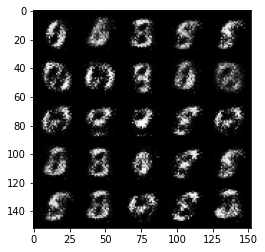

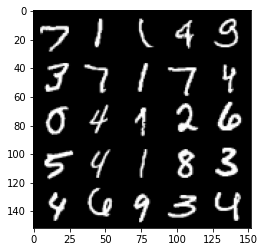

Epoch 14, step 7000: Generator loss: 4.080029844284061, discriminator loss: 0.05764451777189971


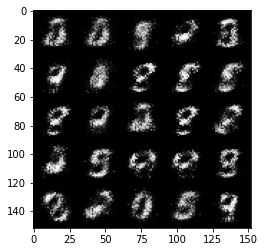

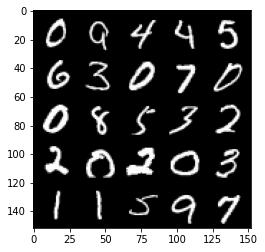

Epoch 15, step 7500: Generator loss: 4.275431730270386, discriminator loss: 0.049655897788703454


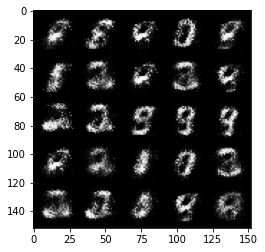

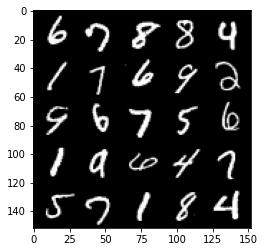

Epoch 17, step 8000: Generator loss: 4.005365378856657, discriminator loss: 0.0635862069576979


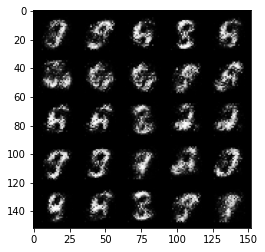

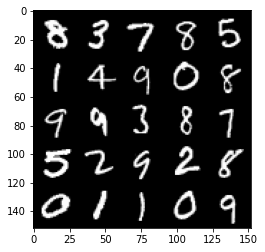

Epoch 18, step 8500: Generator loss: 4.067855875492095, discriminator loss: 0.06856077794730671


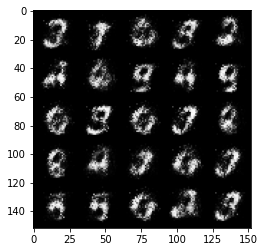

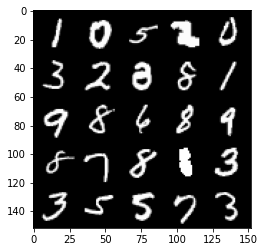

Epoch 19, step 9000: Generator loss: 4.345029761314397, discriminator loss: 0.05094468709826471


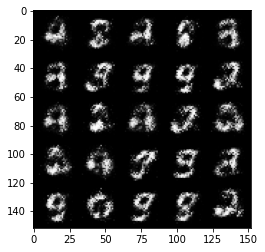

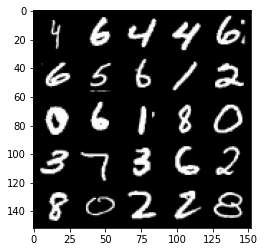

Epoch 20, step 9500: Generator loss: 4.40365012836456, discriminator loss: 0.048117607481777624


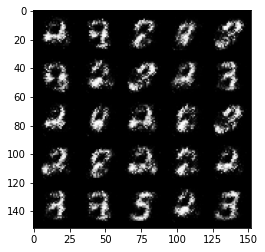

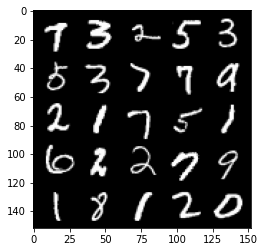

Epoch 21, step 10000: Generator loss: 4.381785894393922, discriminator loss: 0.05137880857661362


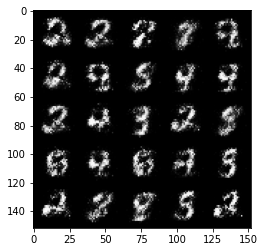

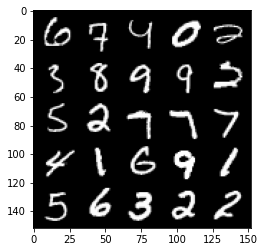

Epoch 22, step 10500: Generator loss: 4.234271902561185, discriminator loss: 0.06492610776051881


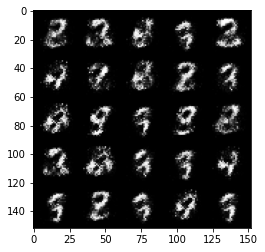

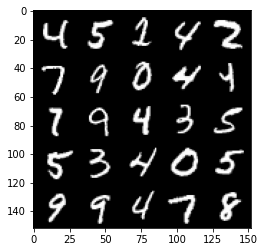

Epoch 23, step 11000: Generator loss: 4.066740520000454, discriminator loss: 0.07994150608032946


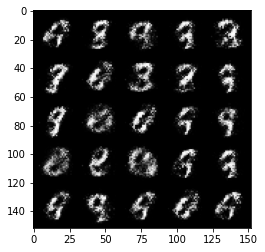

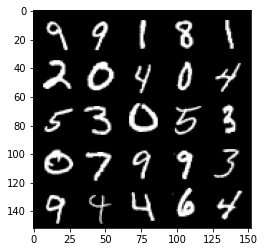

Epoch 24, step 11500: Generator loss: 4.163492438793182, discriminator loss: 0.07000952500849968


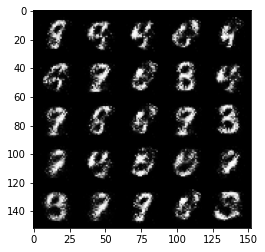

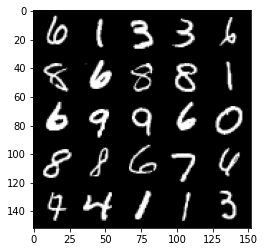

Epoch 25, step 12000: Generator loss: 4.203619201183321, discriminator loss: 0.07825194897502666


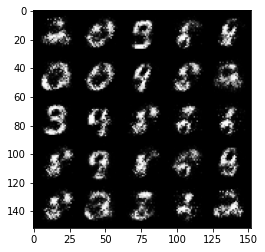

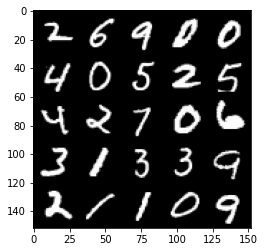

Epoch 26, step 12500: Generator loss: 4.270645995140075, discriminator loss: 0.07060938990861175


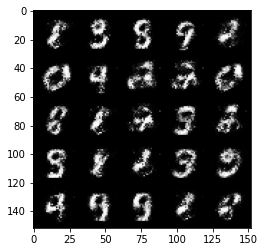

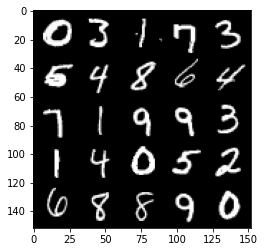

Epoch 27, step 13000: Generator loss: 4.0976691250801105, discriminator loss: 0.08785569363832471


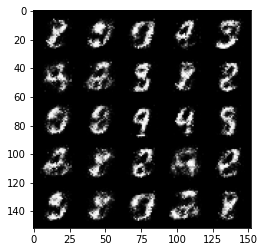

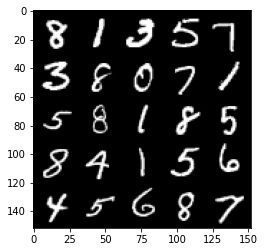

Epoch 28, step 13500: Generator loss: 4.153104462623598, discriminator loss: 0.0895191383138299


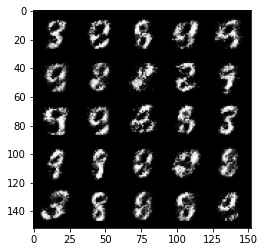

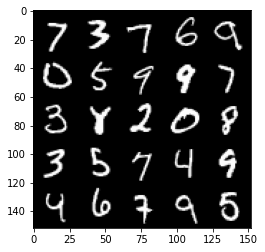

Epoch 29, step 14000: Generator loss: 4.017819198131563, discriminator loss: 0.10543572166562089


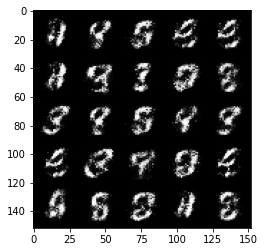

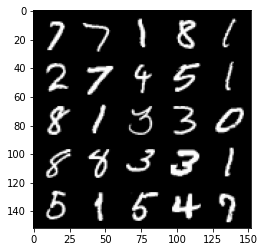

Epoch 30, step 14500: Generator loss: 3.8013096075058, discriminator loss: 0.10544835735857482


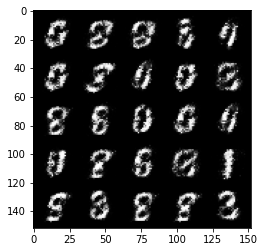

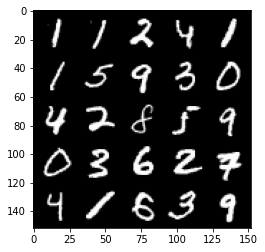

Epoch 31, step 15000: Generator loss: 3.8197770371437074, discriminator loss: 0.09566333142668001


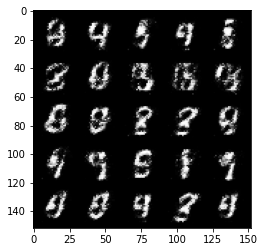

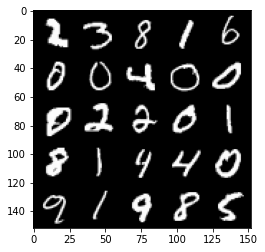

Epoch 33, step 15500: Generator loss: 3.791610038280486, discriminator loss: 0.10436896860599511


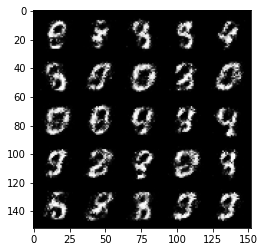

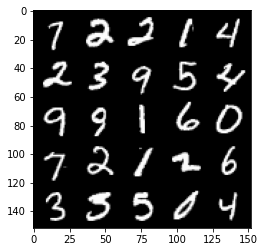

Epoch 34, step 16000: Generator loss: 3.921406235218047, discriminator loss: 0.10636006668210034


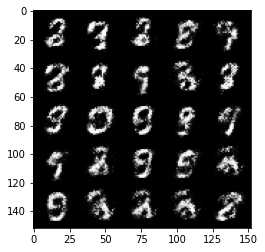

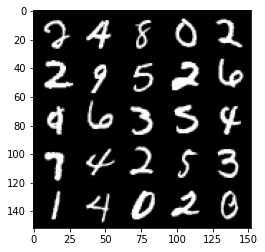

Epoch 35, step 16500: Generator loss: 3.679766273498534, discriminator loss: 0.13243095026910306


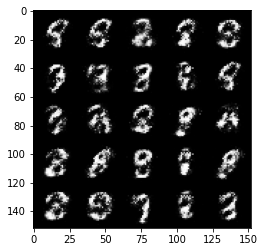

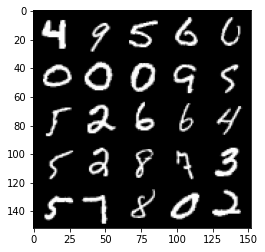

Epoch 36, step 17000: Generator loss: 3.6069575057029684, discriminator loss: 0.12942566313594586


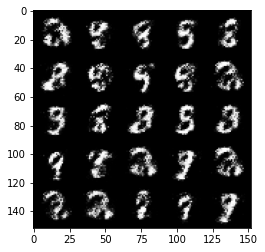

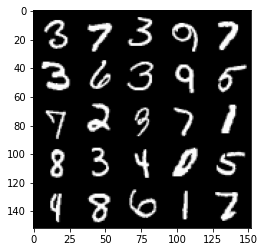

Epoch 37, step 17500: Generator loss: 3.5317504158020046, discriminator loss: 0.13347019670903676


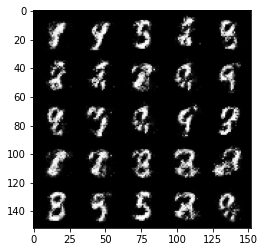

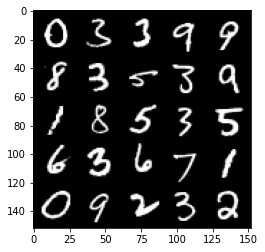

Epoch 38, step 18000: Generator loss: 3.4896856551170354, discriminator loss: 0.13402147435396905


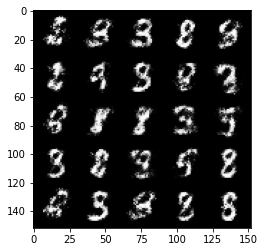

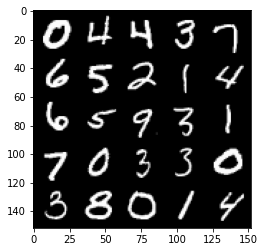

Epoch 39, step 18500: Generator loss: 3.2543416047096256, discriminator loss: 0.15833927635848502


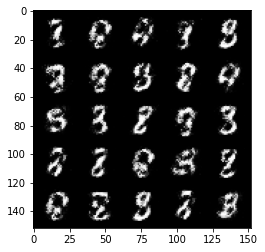

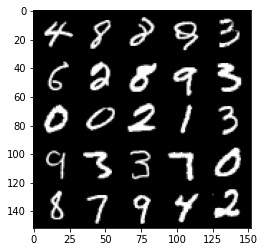

Epoch 40, step 19000: Generator loss: 3.2006864051818855, discriminator loss: 0.14832328671962014


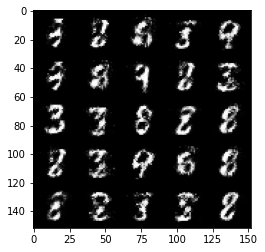

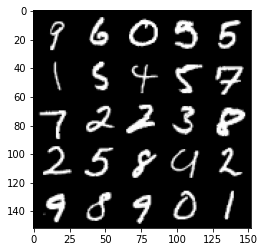

Epoch 41, step 19500: Generator loss: 3.288035241603849, discriminator loss: 0.15503691916167725


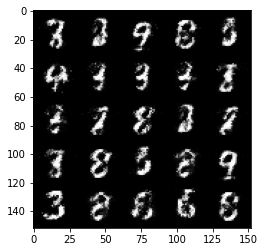

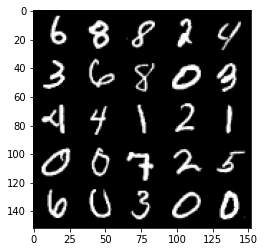

Epoch 42, step 20000: Generator loss: 3.216613659858707, discriminator loss: 0.1500227226614954


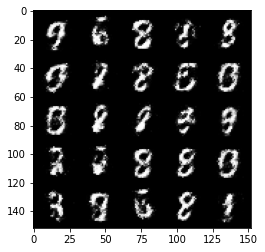

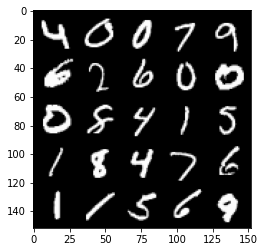

Epoch 43, step 20500: Generator loss: 3.0722962212562575, discriminator loss: 0.17056186881661398


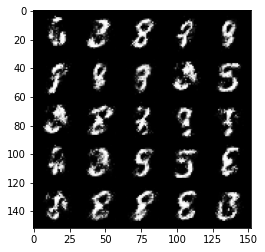

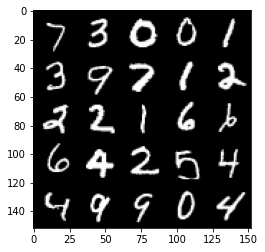

Epoch 44, step 21000: Generator loss: 3.063988969802856, discriminator loss: 0.1588559568673374


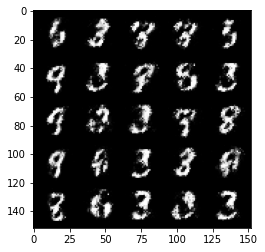

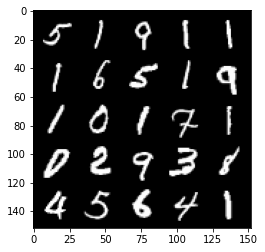

Epoch 45, step 21500: Generator loss: 3.176479771137234, discriminator loss: 0.15027263690531262


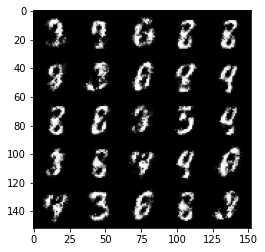

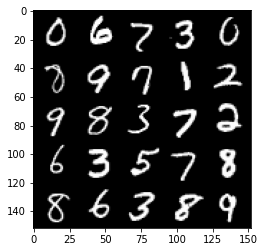

Epoch 46, step 22000: Generator loss: 3.0359990458488473, discriminator loss: 0.17855559454858302


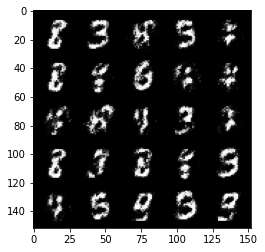

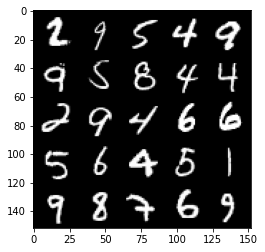

Epoch 47, step 22500: Generator loss: 3.129514709472656, discriminator loss: 0.15326213532686217


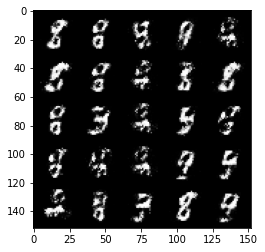

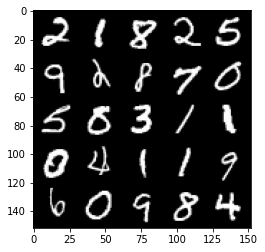

Epoch 49, step 23000: Generator loss: 3.190377558708187, discriminator loss: 0.14929188393056397


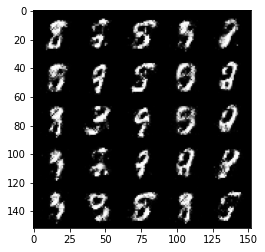

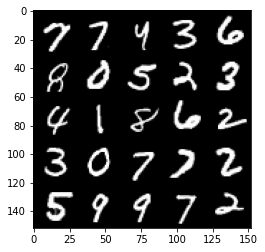

Epoch 50, step 23500: Generator loss: 3.250815711021422, discriminator loss: 0.14729115821421146


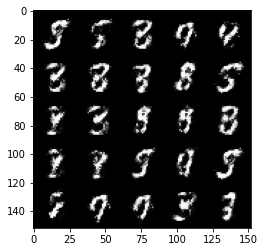

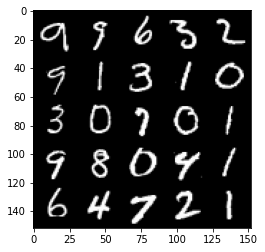

Epoch 51, step 24000: Generator loss: 3.1287398986816437, discriminator loss: 0.15964898569881902


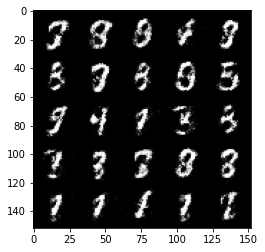

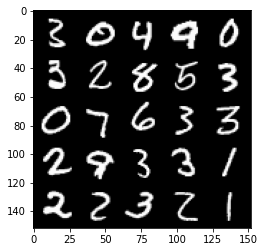

Epoch 52, step 24500: Generator loss: 3.051557604789733, discriminator loss: 0.1740989488959314


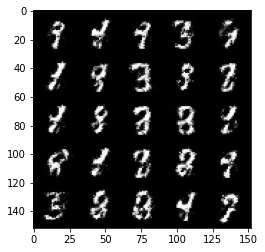

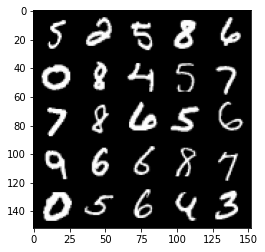

Epoch 53, step 25000: Generator loss: 3.0272292141914385, discriminator loss: 0.16168241788446913


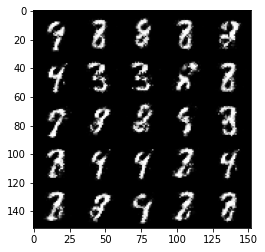

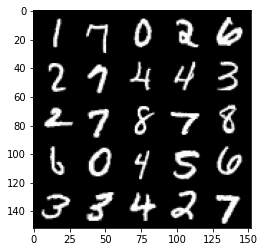

Epoch 54, step 25500: Generator loss: 2.930277619361875, discriminator loss: 0.18780940796434875


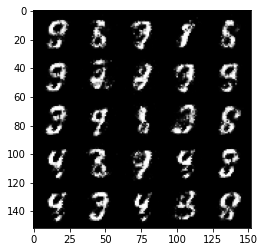

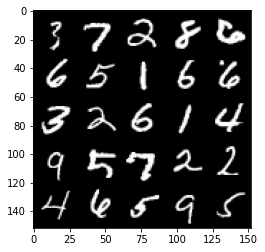

Epoch 55, step 26000: Generator loss: 2.8699762053489684, discriminator loss: 0.19016252717375765


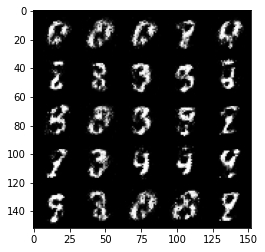

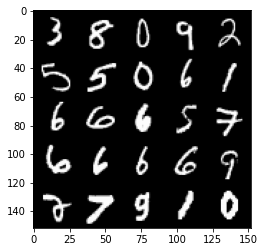

Epoch 56, step 26500: Generator loss: 3.0401564426422114, discriminator loss: 0.17440811172127715


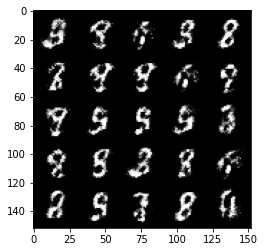

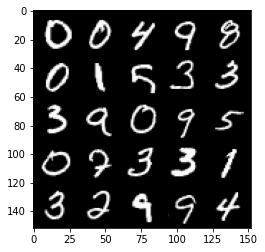

Epoch 57, step 27000: Generator loss: 2.768936315059664, discriminator loss: 0.213731402248144


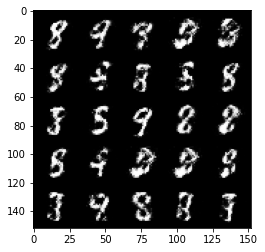

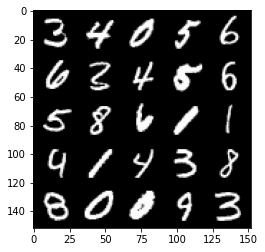

Epoch 58, step 27500: Generator loss: 2.848981823921204, discriminator loss: 0.19302776275575154


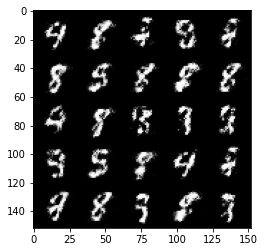

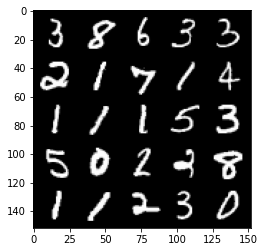

In [14]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
       

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
